In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import h5py

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [16, 8]
rcParams['font.family'] = ['sans-serif']
rcParams['axes.unicode_minus'] = False 

In [4]:
from matplotlib.font_manager import _rebuild
_rebuild()

In [5]:
pd.read_hdf('../data/002162.h5', '/stock/details')

,id,time,price,price_change,volume,turnover,nature
0,002162_2007-08-23,09:25:04,19.879999,19.879999,26465,52612420,buy
1,002162_2007-08-23,09:30:10,19.799999,-0.080000,23132,45802944,sell
2,002162_2007-08-23,09:30:15,19.799999,0.000000,203,401940,buy
3,002162_2007-08-23,09:30:20,19.799999,0.000000,269,532620,buy
4,002162_2007-08-23,09:30:25,19.490000,-0.310000,605,1179145,sell
...,...,...,...,...,...,...,...
3591540,002162_2016-09-30,14:56:42,6.590000,-0.010000,25,16475,sell
3591541,002162_2016-09-30,14:56:51,6.590000,0.000000,80,52720,sell
3591542,002162_2016-09-30,14:56:54,6.590000,0.000000,199,131141,sell
3591543,002162_2016-09-30,14:57:00,6.590000,0.000000,14,9226,sell


In [6]:
stocks = pd.read_hdf('../data/002162.h5', '/stock/stocks')

In [7]:
stocks

,id,opening_price,highest_price,closing_price,floor_price,trading_volume,transaction_amount
0,002162_2007-08-23,19.879999,19.950001,16.030001,15.54,49007071,817153551
1,002162_2007-08-24,15.100000,15.910000,15.360000,15.10,14034293,216360769
2,002162_2007-08-27,15.550000,15.800000,15.180000,15.00,8497646,130200302
3,002162_2007-08-28,15.180000,15.800000,15.440000,14.15,11736924,175879045
4,002162_2007-08-29,15.140000,15.150000,14.680000,14.55,4653887,69075369
...,...,...,...,...,...,...,...
2187,002162_2016-09-26,6.770000,6.780000,6.510000,6.50,7885080,52287446
2188,002162_2016-09-27,6.510000,6.630000,6.620000,6.40,6482421,42134855
2189,002162_2016-09-28,6.600000,6.620000,6.530000,6.51,3400200,22246074
2190,002162_2016-09-29,6.550000,6.590000,6.540000,6.53,3600913,23607688


In [8]:
f = h5py.File('../data/002162.h5','r')

In [9]:
for i in f.items():
    print(i)

('stock', <HDF5 group "/stock" (2 members)>)


In [10]:
for i in f['/stock'].items():
    print(i)

('details', <HDF5 dataset "details": shape (3591545,), type "|V74">)
('stocks', <HDF5 dataset "stocks": shape (2192,), type "|V52">)


In [11]:
training_set = stocks['closing_price'].values
training_set = training_set.reshape(training_set.shape[0], 1)

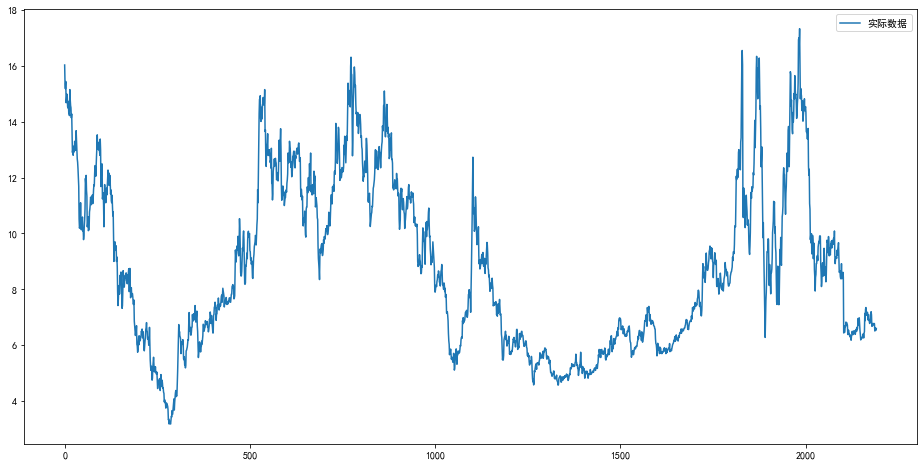

In [12]:
plt.plot(training_set, label = '实际数据')
plt.legend()

In [13]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 20
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.50)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:train_size])))
trainY = Variable(torch.Tensor(np.array(y[:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:])))
testY = Variable(torch.Tensor(np.array(y[train_size:])))

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [24]:
nn.GRU?

In [31]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, h_out = self.gru(x, (h_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [32]:

num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

# lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = GRU(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03957
Epoch: 100, loss: 0.00089
Epoch: 200, loss: 0.00081
Epoch: 300, loss: 0.00076
Epoch: 400, loss: 0.00073
Epoch: 500, loss: 0.00071
Epoch: 600, loss: 0.00069
Epoch: 700, loss: 0.00069
Epoch: 800, loss: 0.00068
Epoch: 900, loss: 0.00068
Epoch: 1000, loss: 0.00067
Epoch: 1100, loss: 0.00067
Epoch: 1200, loss: 0.00067
Epoch: 1300, loss: 0.00067
Epoch: 1400, loss: 0.00067
Epoch: 1500, loss: 0.00067
Epoch: 1600, loss: 0.00067
Epoch: 1700, loss: 0.00067
Epoch: 1800, loss: 0.00067
Epoch: 1900, loss: 0.00067
Epoch: 2000, loss: 0.00067
Epoch: 2100, loss: 0.00067
Epoch: 2200, loss: 0.00067
Epoch: 2300, loss: 0.00067
Epoch: 2400, loss: 0.00067
Epoch: 2500, loss: 0.00067
Epoch: 2600, loss: 0.00067
Epoch: 2700, loss: 0.00067
Epoch: 2800, loss: 0.00067
Epoch: 2900, loss: 0.00067


In [33]:
lstm.eval()

GRU(
  (gru): GRU(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [34]:
pres = []
pre = None
for i in range(testX.shape[0]):
    if pre is None:
        pre = lstm(testX[i].reshape(1, seq_length, 1))
    else:
        d = testX[i]
        d[-1] = pre.item()
        pre = lstm(d.reshape(1, seq_length, 1))
    pres.append(pre.item())
    
dp = sc.inverse_transform(np.asarray(pres).reshape(testX.shape[0], 1))
xpd = np.asarray(range(train_size, train_size + test_size))

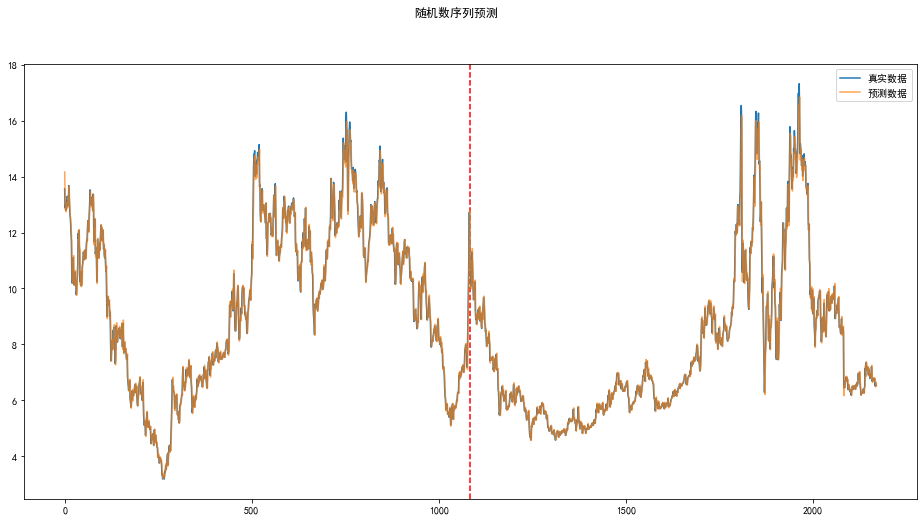

In [35]:
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label='真实数据')
plt.plot(data_predict, label='预测数据', alpha=0.7)
# plt.plot(xpd, dp, label='二次预测')
plt.suptitle('随机数序列预测')
plt.legend()
plt.savefig('../data/002162', dpi=300)
plt.show()